# Import Libraries

In [10]:
import pandas as pd
import numpy as np
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
import os
from collections import Counter
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation, NMF
from gensim.models import HdpModel, CoherenceModel
import gensim.corpora as corpora
import hdp
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_colwidth', None)  # Show full content in each cell
pd.set_option('display.width', 1000)  # Set max width

# Load spaCy's English model
nlp = spacy.load('en_core_web_sm')

# Modules

In [2]:
def preprocess_text(text):

    doc = nlp(text.lower().strip())  # Lowercase and remove whitespace
    
# Process tokens: lemmatize, filter stopwords/punct/numbers
    tokens = [
        token.lemma_ 
        for token in doc 
        if (
            (not token.is_stop) and
            (not token.is_punct) and 
            (token.is_alpha)
        )
    ]

    return ' '.join(tokens)

In [3]:
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys


In [4]:
def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

In [5]:
def get_top_n_words(n , n_topics, keys, document_term_matrix, count_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

In [6]:
def get_mean_topic_vectors(n_topics, keys, two_dim_vectors):
    '''
    returns a list of centroid vectors from each predicted topic category
    '''
    mean_topic_vectors = []
    for t in range(n_topics):
        articles_in_that_topic = []
        for i in range(len(keys)):
            if keys[i] == t:
                articles_in_that_topic.append(two_dim_vectors[i])    
        
        articles_in_that_topic = np.vstack(articles_in_that_topic)
        mean_article_in_that_topic = np.mean(articles_in_that_topic, axis=0)
        mean_topic_vectors.append(mean_article_in_that_topic)
    return mean_topic_vectors

In [7]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[-n_top_words:][::-1]
        top_features = feature_names[top_features_ind]
        print(f"Topic {topic_idx + 1}:  {' '.join(top_features)}")


# Pre-Processing

In [14]:
# Load dataset
df = pd.DataFrame()
for i in range(1,3):
    q_df = pd.read_csv(os.getcwd() + '/video_data' + str(i) + '.csv')
    df = pd.concat([df , q_df])
df['processed_title'] = df['title'].apply(preprocess_text)

In [36]:
# TF-IDF vectorization
token_pattern = r"(?u)\b[a-zA-Z]{3,}\b"
tf_vectorizer = TfidfVectorizer(
    min_df= 2 ,
    max_df=0.8 , 
    ngram_range=(1,2), 
    use_idf= True, 
    norm= 'l2', 
    token_pattern= token_pattern
    )
tfidf = tf_vectorizer.fit_transform(df['processed_title'])

tfidf_df = pd.DataFrame(tfidf.toarray(), columns= tf_vectorizer.get_feature_names_out(), index=df.index)
tfidf_df.shape

(2355, 2374)

# Modelling

In [22]:
# Define number of topics
n_topics = 10

### LSA

This is effectively just a truncated singular value decomposition of a (very high-rank and sparse) document-term matrix, with only the n_topics largest singular values preserved.

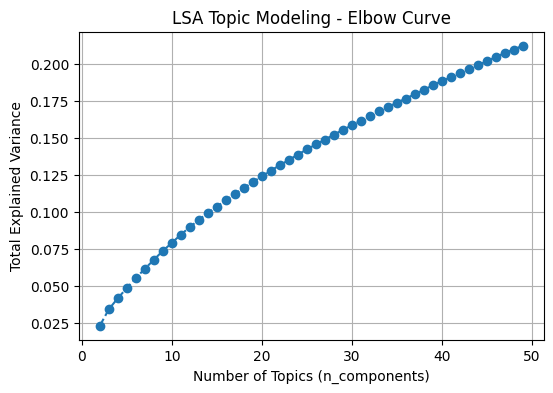

In [18]:
explained_variances = []
k_range = range(2, 50)  # Try different topic numbers

for k in k_range:
    svd = TruncatedSVD(n_components=k)
    svd.fit(tfidf_df)
    explained_variances.append(svd.explained_variance_ratio_.sum())

# Plot elbow curve
plt.figure(figsize=(6, 4))
plt.plot(k_range, explained_variances, marker='o', linestyle='--')
plt.xlabel('Number of Topics (n_components)')
plt.ylabel('Total Explained Variance')
plt.title('LSA Topic Modeling - Elbow Curve')
plt.grid(True)
plt.show()


10 is optimal n_topics

In [19]:
lsa_model = TruncatedSVD(n_components=n_topics)
lsa_topic_matrix = lsa_model.fit_transform(tfidf_df)

In [ ]:
'''
Taking the  argmax of each headline in this topic matrix will give the predicted topics of each headline in the sample. 
We can then sort these into counts of each topic.
  '''

lsa_keys = get_keys(lsa_topic_matrix)
lsa_categories, lsa_counts = keys_to_counts(lsa_keys)

top_n_words_lsa = get_top_n_words(10, n_topics, lsa_keys, tfidf, tf_vectorizer)

for i in range(len(top_n_words_lsa)):
    print("Topic {}: ".format(i+1), top_n_words_lsa[i])

Topic 1:  bitcoin crypto news break dump btc bitcoin crypto happen sell bad
Topic 2:  crypto week market crash crypto market blockchain big trump invest week crypto
Topic 3:  explain programmer programmer explain ethereum bitcoin blockchain hack ethereum programmer eos happen
Topic 4:  buy buy bitcoin bitcoin million token altcoin right coin rich crypto buy
Topic 5:  deepak wadhwa deepak wadhwa new link new referal referal link referal easy trading
Topic 6:  bull run bull run crypto bull bitcoin bull bull market market crypto bitcoin altcoin
Topic 7:  altcoin cardano stimulus check stimulus check month gain altcoin season bitcoin altcoin season
Topic 8:  ethereum price bitcoin price prediction price prediction bitcoin moon icos ethereum icos ethereum price
Topic 9:  coin crypto coin urgent alt millionaire chance crypto alt coin pump change
Topic 10:  trading money stockmarket stock beginner market invest day strategy deeptalk


### LDA
 LDA is instead a generative probabilistic process, designed with the specific goal of uncovering latent topic structure in text corpora.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer(max_df=0.95, min_df=2)
count_matrix = count_vectorizer.fit_transform(df['processed_title'])


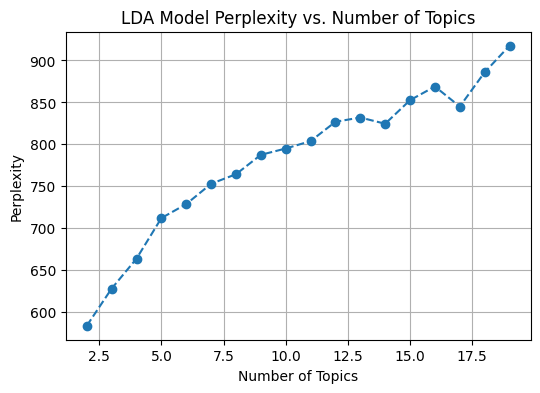

In [24]:
perplexities = []
k_range = range(2, 20)

for k in k_range:
    lda = LatentDirichletAllocation(n_components=k, random_state=42)
    lda.fit(count_matrix)
    perplexities.append(lda.perplexity(count_matrix))  # Lower is better

# Plotting
plt.figure(figsize=(6, 4))
plt.plot(k_range, perplexities, marker='o', linestyle='--')
plt.xlabel('Number of Topics')
plt.ylabel('Perplexity')
plt.title('LDA Model Perplexity vs. Number of Topics')
plt.grid(True)
plt.show()

In [25]:
lda_model = LatentDirichletAllocation(n_components=n_topics, learning_method='online', 
                                          random_state=0, verbose=0)
lda_topic_matrix = lda_model.fit_transform(tfidf)

In [ ]:
'''
Once again, we take the  argmax of each entry in the topic matrix 
to obtain the predicted topic category for each headline. 
These topic categories can then be characterised by their most frequent words.
  '''
lda_keys = get_keys(lda_topic_matrix)
lda_categories, lda_counts = keys_to_counts(lda_keys)

top_n_words_lda = get_top_n_words(10, n_topics, lda_keys, count_matrix, count_vectorizer)

for i in range(len(top_n_words_lda)):
    print("Topic {}: ".format(i+1), top_n_words_lda[i])

Topic 1:  bitcoin market crypto stock trump explain crash invest explode wadhwa
Topic 2:  crypto bitcoin coin bull run explain market buy guide programmer
Topic 3:  bitcoin crypto ledger explain global cap safe millionaire fed bonus
Topic 4:  new deepak link wadhwa referal crypto easy january bitcoin rich
Topic 5:  crypto step wallet beginner bitcoin guide card watch trade defi
Topic 6:  bitcoin crypto explain ethereum programmer news week btc break blockchain
Topic 7:  bitcoin crypto trading strategy million stockmarket crash day option dump
Topic 8:  bitcoin crypto news explain price ethereum blockchain bullish altcoin market
Topic 9:  bitcoin money crypto check stimulus big buy altcoin second market
Topic 10:  bitcoin crypto buy altcoin price prediction know happen right need


### Non-Negative Matrix Factorization (NMF)
Non-Negative Matrix Factorization is a statistical method to reduce the dimension of the input corpora. It uses factor analysis method to provide comparatively less weightage to the words with less coherence.

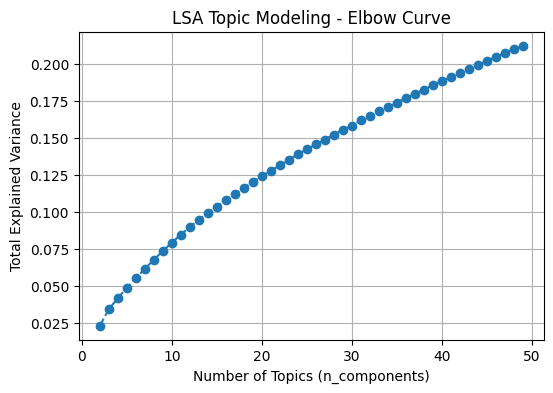

In [29]:
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD

explained_variances = []
k_range = range(2, 50)  # Try different topic numbers

for k in k_range:
    svd = TruncatedSVD(n_components=k)
    svd.fit(tfidf_df)
    explained_variances.append(svd.explained_variance_ratio_.sum())

# Plot elbow curve
plt.figure(figsize=(6, 4))
plt.plot(k_range, explained_variances, marker='o', linestyle='--')
plt.xlabel('Number of Topics (n_components)')
plt.ylabel('Total Explained Variance')
plt.title('LSA Topic Modeling - Elbow Curve')
plt.grid(True)
plt.show()


In [30]:
nmf_model = NMF(n_components= 10)
nmf_topic_matrix = nmf_model.fit(tfidf)

In [37]:
tfidf_feature_names = tf_vectorizer.get_feature_names_out()
print_top_words(
    nmf_model,
    tfidf_feature_names,
    8
)


Topic 1:  bitcoin bitcoin price price break sell dump bitcoin bitcoin news
Topic 2:  crypto week news week crypto crash market crypto news crypto market
Topic 3:  explain programmer programmer explain ethereum programmer blockchain crash github happen
Topic 4:  buy buy bitcoin crypto buy million token buy crypto right year
Topic 5:  deepak wadhwa deepak wadhwa new link new referal referal referal link
Topic 6:  bull run bull run crypto bull market bull market bitcoin bull million
Topic 7:  altcoin bitcoin altcoin season altcoin season soon gain cardano right
Topic 8:  ethereum price bitcoin price prediction price prediction bitcoin ethereum ethereum price icos
Topic 9:  coin crypto coin chance urgent alt alt coin tiny meme
Topic 10:  trading money strategy stockmarket stock beginner trading strategy guide


### Hierarchical Dirichlet Process (HDP)

In [38]:
data = df['processed_title'].apply(lambda x: x.split())
id2word = corpora.Dictionary(data)
corpus = [id2word.doc2bow(text) for text in data]

In [39]:
param_grid_hdp = {
    'gamma': [1, 5, 10],      # Controls topic sparsity (higher = fewer topics)
    'alpha': [0.1, 0.5, 1.0], # Document-level topic concentration
    'kappa': [0.3, 0.5, 0.7], # Learning rate
    'tau': [32.0, 64.0]       # Slow-down parameter
}

best_coherence_hdp = -1
best_params_hdp = {}

for gamma in param_grid_hdp['gamma']:
    for alpha in param_grid_hdp['alpha']:
        for kappa in param_grid_hdp['kappa']:
            for tau in param_grid_hdp['tau']:
                # Train HDP model
                model = HdpModel(
                    corpus=corpus,
                    id2word=id2word,
                    gamma=gamma,
                    alpha=alpha,
                    kappa=kappa,
                    tau=tau
                )
                
                # Calculate coherence score
                coherence = CoherenceModel(
                    model=model,
                    texts=data,
                    dictionary=id2word,
                    coherence='c_v'
                ).get_coherence()
                
                # Update best parameters
                if coherence > best_coherence_hdp:
                    best_coherence_hdp = coherence
                    best_params_hdp = {
                        'gamma': gamma,
                        'alpha': alpha,
                        'kappa': kappa,
                        'tau': tau
                    }

print(f"Best HDP Coherence: {best_coherence_hdp}")
print(f"Best HDP Parameters: {best_params_hdp}")

Best HDP Coherence: 0.7306649143701097
Best HDP Parameters: {'gamma': 10, 'alpha': 0.5, 'kappa': 0.7, 'tau': 64.0}


In [40]:
hdp_model = HdpModel(
    corpus=corpus,
    id2word=id2word,
    gamma=10,
    alpha=0.5,
    kappa=0.7,
    tau= 64)

hdptopics = hdp_model.show_topics(formatted=False)
print(len(hdptopics))

20


In [41]:
# Evaluate topic coherence
coherence_model = CoherenceModel(
    model=hdp_model,
    texts=data,
    dictionary=id2word,
    coherence='c_v'
)
coherence_score = coherence_model.get_coherence()
print(f"Coherence Score: {coherence_score}")

Coherence Score: 0.728833630121469


In [42]:
for topic_id, topic_words in hdptopics:
    words = [word for word, _ in topic_words]
    print(f"Topic {topic_id}: {', '.join(words)}")

Topic 0: bitcoin, penny, extrinsic, killing, hitler, reshape, regret, death, lose, manifest, career, iota, efani, stonk, beacon, ln, vom, pyramid, walmart, trader
Topic 1: bitcoin, specie, earth, shikha, market, change, step, deep, crypto, watch, breeze, yoni, ultimate, bombshell, measure, tweet, flash, wtf, srinivasan, level
Topic 2: crypto, gavin, bitcoin, programmer, incoming, mil, cryptotrade, machine, futurist, economy, weekend, insane, 참고할, teaser, hodl, arjun, topic, hysteria, roadster, social
Topic 3: bitcoin, retire, worldcoin, record, intrinsic, currency, shortage, controversial, major, divergence, nse, hoskinson, motivated, crypto, miner, fight, dandelion, score, express, narrative
Topic 4: crypto, coin, bitcoin, omg, define, nse, drizzle, airpod, srk, sharding, click, lakh, ethereum, cocos, gen, closed, calculation, dubai, today, cpi
Topic 5: bitcoin, anymore, dame, roadster, news, ivan, crypto, bitboy, story, feel, prep, calm, giveaway, selfish, portuguese, oblivion, tie, 

### Gaussian LDA